# install and import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.8 MB/s eta 0:00:00


In [22]:
import tensorflow as tf
from transformers import (
    BertTokenizer,
    BertModel,
    RobertaModel,
    RobertaTokenizer,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/preprocess1FinalBalanced.csv')

In [6]:
df.shape

(21912, 2)

In [7]:
df=df.dropna()

In [8]:
df.text=df.text.astype(str)

In [9]:
df = df.drop_duplicates()

In [10]:
df.shape

(21909, 2)

In [11]:
df.head()

,sentiment,text
0,positive,♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️...
1,positive,franca harmet edjdadna wa waldina wa mine ba3d...
2,positive,الله يبارك ،هدا الخير ويقولوا الجزايري ماشي خد...
3,positive,bonjour doc que ce soit sur les sites français...
4,positive,dido الدوله حبيبي حاله ازمه ماليه الازمه باقي ...


In [12]:
class_names=["negative","neutral","positive"]
label_mapping = {'positive':2, 'negative':0, 'neutral':1}
df['sentiment'] =[label_mapping[label] for label in df['sentiment']]

In [13]:
df['sentiment'].value_counts()

0    7304
1    7304
2    7301
Name: sentiment, dtype: int64

# Proccess

In [16]:
PRE_TRAINED_MODEL_NAME = 'xlm-roberta-base'

In [23]:
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## exemple

In [24]:
sample_txt = "السلام عليكم واش راك خويا cv؟"

In [25]:
encoding = tokenizer.encode_plus(
  sample_txt,
  truncation=True,
  max_length=32,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt'
)

In [26]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([     0,  11945, 101387,     65,  12326,      6,  58730,   6844,   2796,
        115158,   1245,      2,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1])

In [27]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

32


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [28]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['<s>',
 '▁السلام',
 '▁عليكم',
 '▁و',
 'اش',
 '▁',
 'راك',
 '▁خو',
 'يا',
 '▁cv',
 '؟',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

# sequence length

In [29]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


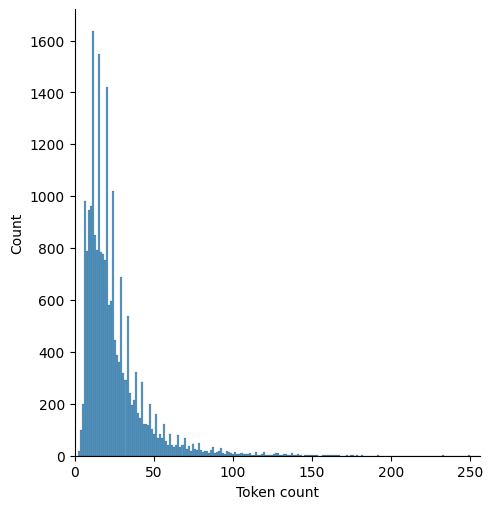

In [30]:
sns.displot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [31]:
MAX_LEN = 100

# Data

In [32]:
class SentimentDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      return_tensors='pt'
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [33]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=21)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=21)

In [34]:
df_train.shape, df_val.shape, df_test.shape

((13145, 2), (4382, 2), (4382, 2))

In [35]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentimentDataset(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [36]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [37]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [38]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


# Sentiment

In [39]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.9.attention.output.dense.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.intermediate.dense.weight', 'roberta.encoder.layer.11.attention.self.key.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'roberta.pooler.dense.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.8.attention.output.dense.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.output.dense.weight', 'roberta.encoder.layer.7.attention.self.query.bias', 'roberta.encoder.layer.5.output.LayerNorm.bias', 'lm_head.bias', 'roberta.encoder.layer.9.attention.self.value.weig

In [40]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [41]:
model = SentimentClassifier(3)
model = model.to(device)

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertModel: ['roberta.encoder.layer.9.attention.output.dense.bias', 'roberta.encoder.layer.10.attention.self.value.bias', 'roberta.encoder.layer.9.attention.self.key.weight', 'roberta.encoder.layer.11.attention.output.LayerNorm.weight', 'roberta.encoder.layer.9.intermediate.dense.weight', 'roberta.encoder.layer.11.attention.self.key.weight', 'roberta.encoder.layer.11.output.LayerNorm.bias', 'roberta.pooler.dense.weight', 'roberta.encoder.layer.10.intermediate.dense.bias', 'roberta.encoder.layer.11.attention.output.dense.weight', 'roberta.encoder.layer.8.attention.output.dense.weight', 'roberta.embeddings.word_embeddings.weight', 'roberta.encoder.layer.10.attention.output.LayerNorm.bias', 'roberta.encoder.layer.9.output.dense.weight', 'roberta.enc

In [42]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 100])
torch.Size([16, 100])


In [43]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4489, 0.2447, 0.3063],
        [0.3208, 0.2767, 0.4025],
        [0.5359, 0.1883, 0.2758],
        [0.3623, 0.2838, 0.3539],
        [0.3855, 0.2095, 0.4049],
        [0.4383, 0.1962, 0.3656],
        [0.3915, 0.2832, 0.3253],
        [0.4641, 0.2300, 0.3059],
        [0.4204, 0.1977, 0.3819],
        [0.3794, 0.2649, 0.3557],
        [0.3986, 0.2813, 0.3201],
        [0.4950, 0.2089, 0.2961],
        [0.3634, 0.3036, 0.3329],
        [0.3993, 0.2172, 0.3835],
        [0.3899, 0.2064, 0.4038],
        [0.3228, 0.2375, 0.4397]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# Training

In [44]:
EPOCHS = 15

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):

  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids,attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [46]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
from collections import defaultdict

In [48]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/PFE/roberta.bin')
    best_accuracy = val_acc

Epoch 1/15
----------
Train loss 0.9940798763376083 accuracy 0.4859642449600608
Val   loss 0.9944783170727918 accuracy 0.4755819260611593

Epoch 2/15
----------
Train loss 0.9359863045151796 accuracy 0.5161658425256751
Val   loss 0.887979168961518 accuracy 0.5497489730716568

Epoch 3/15
----------
Train loss 0.8956524408139162 accuracy 0.5475085583872195
Val   loss 0.9527249342768732 accuracy 0.5449566408032862

Epoch 4/15
----------
Train loss 0.883306133921129 accuracy 0.5601369341955116
Val   loss 0.8788773323932704 accuracy 0.5775901414879051

Epoch 5/15
----------
Train loss 0.8552156520730968 accuracy 0.5740585774058578
Val   loss 0.8742340000441474 accuracy 0.5791875855773619

Epoch 6/15
----------
Train loss 0.778075368716914 accuracy 0.6486877139596804
Val   loss 0.7613642055840388 accuracy 0.6743496120492926

Epoch 7/15
----------
Train loss 0.6722081931366828 accuracy 0.7192088246481552
Val   loss 0.7388586704857159 accuracy 0.6919214970333181

Epoch 8/15
----------
Train lo

In [49]:
h=torch.Tensor([history['train_acc'], history['val_acc'] ])

In [50]:
h

tensor([[0.4860, 0.5162, 0.5475, 0.5601, 0.5741, 0.6487, 0.7192, 0.7633, 0.7950,
         0.8178, 0.8381, 0.8488, 0.8602, 0.8669, 0.8760],
        [0.4756, 0.5497, 0.5450, 0.5776, 0.5792, 0.6743, 0.6919, 0.7177, 0.7382,
         0.7332, 0.7462, 0.7373, 0.7412, 0.7556, 0.7613]])

(0.0, 1.0)

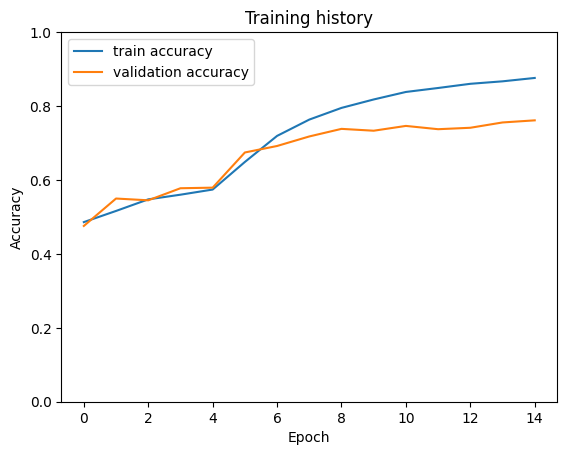

In [51]:
plt.plot(h[0], label='train accuracy')
plt.plot(h[1], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# evalution

In [53]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [54]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [52]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print("accuracy score: ",test_acc.item())

accuracy score:  0.7717937015061616


In [55]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.79      0.81      0.80      1473
     neutral       0.68      0.72      0.70      1469
    positive       0.86      0.79      0.82      1440

    accuracy                           0.77      4382
   macro avg       0.78      0.77      0.77      4382
weighted avg       0.78      0.77      0.77      4382



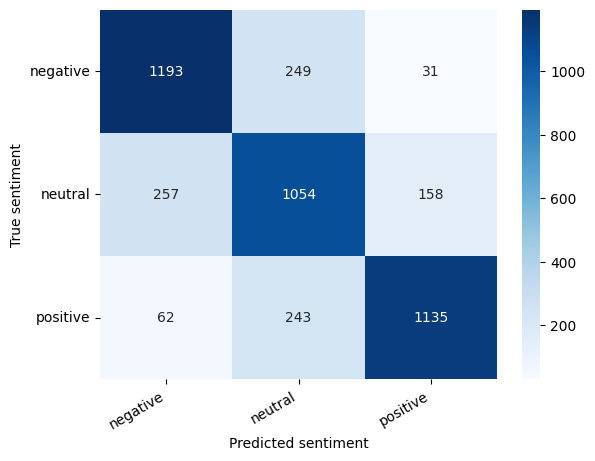

In [56]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [57]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_names': class_names, 'values': y_pred_probs[idx]})

In [58]:
from textwrap import wrap

In [59]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

السلام عليكم تحيه لاخواني واخواتي الجزاءرين

True sentiment: positive


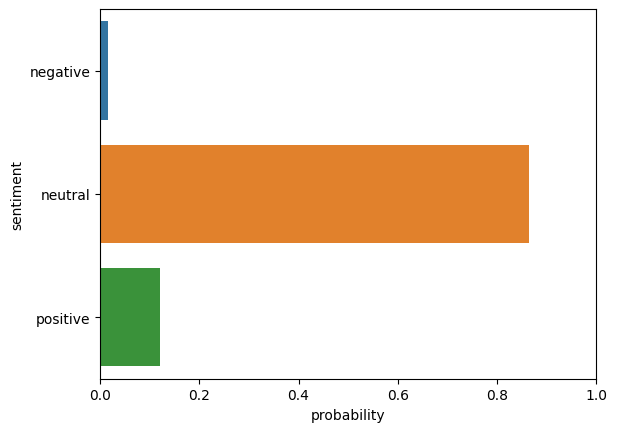

In [60]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

# Test



In [61]:
review_text = "الله يبارك"

In [62]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [63]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: الله يبارك
Sentiment  : positive
